<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/SARIMA_2020_10_05_DONE_(2%EC%A3%BC_%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools


# 돌리기전에, https://colab.research.google.com/drive/1oBXX3k3OOjdivwlDhpLmAqfq5B5dzFR1#scrollTo=AbTlhWommsXE 에 있는 코드도 참고 
# https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a 참고

In [59]:
!pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

Requirement already up-to-date: pykrx in /usr/local/lib/python3.6/dist-packages (0.1.41)


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
from datetime import datetime,timedelta

today=datetime.today().strftime("%Y%m%d")                      # 현재날짜
year1=(datetime.today()-timedelta(365)).strftime('%Y%m%d')     # 현재날짜로부터 1년전 날짜

In [62]:
# 주가 크롤링
from pykrx import stock
df = stock.get_market_ohlcv_by_date(year1, today, "122870")  # (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-07,23000,23700,22850,23400,194442
2019-10-08,23400,23900,22900,23800,148848
2019-10-10,23550,23700,23000,23550,150525
2019-10-11,23800,25200,23650,23950,474910
2019-10-14,24350,25850,24150,25650,558471
...,...,...,...,...,...
2020-09-24,54500,55600,51800,51900,767893
2020-09-25,52600,52900,49400,50900,619816
2020-09-28,52300,57500,51800,57000,1067907


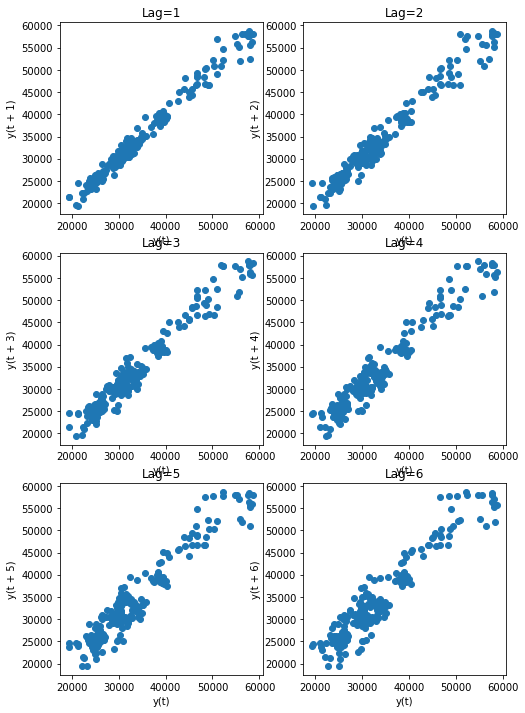

In [63]:
# 선형 모델 적용이 적합한지 확인해보기  (Scatter_plot의 모양이 선형일 수록, 선형모델적용이 타당한 것으로 해석 가능)

from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('YG Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['종가'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

# 그래프의 해석 결과: 
# A linear shape to the plot suggests that an autoregressive model is probably a better choice.
# An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.

In [140]:
df.shape 

(247, 5)

In [146]:
# train : ~ 2020.08.04 (207개) / test : 2020.09.16 ~ (11개, 약 2주) / validation -: 그 사이  // df : 247 x 5

# 개수로 247개 -> train : 207개, validation : 30개, test : 10개로 개수로 데이터셋나눌수 있도록 
#train=df[:'2020-08-04']
#validation=df['2020-08-05':'2020-09-15']
#test=df['2020-09-16':] 

print(df.shape)

# 조정가능한 값 (validation_size , test_size)
validation_size=40
test_size=10

train=df[:len(df)-validation_size]
validation=df[len(df)-validation_size:len(df)-test_size]
test=df[len(df)-test_size:]

print(train.shape)
print(validation.shape)
print(test.shape)

(247, 5)
(207, 5)
(30, 5)
(10, 5)


In [147]:
# column들 중, 종가만 고려한다
train.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
validation.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
test.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)

In [148]:
pip install pmdarima

In [149]:
from pmdarima import auto_arima
import pmdarima as pm
auto = pm.auto_arima(y=train, d=1, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=60,
                            seasonal=True,
                            D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True,
                            max_order=None)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[60]             : AIC=2544.915, Time=1.79 sec
 ARIMA(1,1,0)(1,1,0)[60]             : AIC=2535.753, Time=20.22 sec
 ARIMA(0,1,1)(0,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[60]             : AIC=2546.570, Time=0.77 sec
 ARIMA(1,1,0)(2,1,0)[60]             : AIC=inf, Time=82.57 sec
 ARIMA(1,1,0)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[60]             : AIC=2534.300, Time=5.66 sec
 ARIMA(0,1,0)(2,1,0)[60]             : AIC=inf, Time=25.10 sec
 ARIMA(0,1,0)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[60]             : AIC=2535.718, Time=20.32 sec
 ARIMA

In [150]:
result_seasonal=auto.fit(train)
print(result_seasonal.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  207
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 60)   Log Likelihood               -1265.150
Date:                            Mon, 05 Oct 2020   AIC                           2534.300
Time:                                    08:52:41   BIC                           2540.267
Sample:                                         0   HQIC                          2536.725
                                            - 207                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L60      -0.2759      0.028     -9.680      0.000      -0.332      -0.220
sigma2      1.752e+06   1.98e+05   

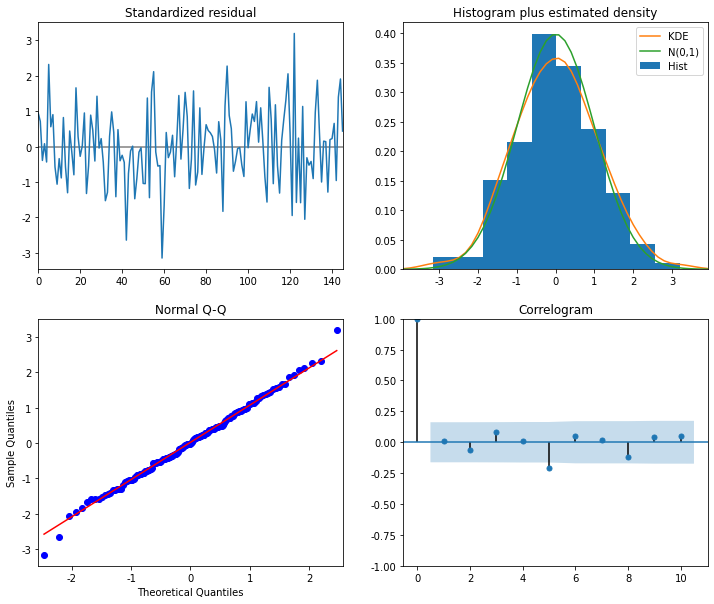

In [151]:
result_seasonal.plot_diagnostics(figsize=(12,10))          
plt.show()  

# 잡음(불규칙요인)의 분포 살피기 (표준잔차, 잔차분포, Normal Q-Q (QQ-Plot), 상관성)

# https://data.library.virginia.edu/diagnostic-plots/ 참고

# 표준화 잔차 (Standardized residual) : 추정 회귀식으로부터 관측치가 얼마나 떨어져 있는지, 절댓값 3이상이면 이상값이 확실, 연구자에 따라 2~3사이의 값을 이상값일 가능성이 달라짐.
# 잔차분포 (Histogram plus estimated density) :  KDE - 커널밀도추정 (정규분포를 스무딩한 것) ( https://darkpgmr.tistory.com/147 참고 ) - 잔차분포(N(0,1))가 KDE와 비슷하다 즉, 잔차가 정규분포 다시말해 회귀모델의 가정중 하나인 잔차가 독립이라는 것을 따른다는 이야기  
# QQ-plot (Normal-QQ) : 수집 데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프 -> 데이터의 정규성 가정에 대한 검토를 가능하게 해줌 -> 집단이 정규성을 따른다면, 점들이 직선의 형태로 그려짐.
# 상관성 (Correlogram): ACF 그래프 

In [152]:
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip # 진행상태바 표시를 위한 tqdm 라이브러리 설치 

In [153]:
#from tqdm import tqdm_notebook as tqdm

#for i in tqdm(range(43),desc='tqdm'):

In [154]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit (trainset으로 이미 학습된 모델)

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    #print('fc : ',fc)
    #print('conf_int : ',conf_int)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in validation['종가']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

In [155]:
forecasts

[43993.111201445194,
 44740.94449280147,
 44857.29192885895,
 44499.11000870109,
 47582.35738541974,
 45641.07547682156,
 43300.3946390442,
 46956.36226032571,
 48573.28853826743,
 47568.57241182619,
 49403.07928503477,
 44689.657477063374,
 46344.666782448716,
 47170.895704359464,
 48487.25884398236,
 50392.843455915696,
 49916.174711153224,
 48534.608401729485,
 48131.998754017775,
 48409.875511180224,
 49772.239724418025,
 52086.6604218305,
 50981.06804899886,
 53389.21852469834,
 58064.977791076744,
 57252.26558550142,
 58226.9451034849,
 58307.346115190085,
 59015.657859300125,
 59441.833699923]

In [156]:
forecasts=pd.DataFrame(forecasts,index=validation.index,columns={'종가'})

In [157]:
forecasts

,종가
날짜,
2020-08-05,43993.111201
2020-08-06,44740.944493
2020-08-07,44857.291929
2020-08-10,44499.110009
2020-08-11,47582.357385
2020-08-12,45641.075477
2020-08-13,43300.394639
2020-08-14,46956.362260
2020-08-18,48573.288538


In [158]:
# train, validfate, testset으로 나누는데, 금융 시계열 데이터이므로, one-step forecast validation 필요 
# https://neocarus.tistory.com/entry/%EB%AA%A8%ED%98%95%EC%9D%98-%EC%A0%81%ED%95%A9%EC%84%B1%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D%EC%9D%84-%EC%88%98%ED%96%89%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95 참고

# train -> 선학습
# validation_set의 one-step forecast validation 하기위한 과정
# 이후, test개수만큼 predict 필요

'''
n_steps = 5
training_period = 0 + n_steps
end = len(df) - n_steps - training_period - 10
validation_size = 20
start = end - validation_size
print('start : ',start,'/ end : ',end,'/ validation_size : ',validation_size,'/ n_step : ',n_steps,'/ training_period : ',training_period)

for i in range(start,end):
  data = df[i:i+training_period+n_steps]

'''

"\nn_steps = 5\ntraining_period = 0 + n_steps\nend = len(df) - n_steps - training_period - 10\nvalidation_size = 20\nstart = end - validation_size\nprint('start : ',start,'/ end : ',end,'/ validation_size : ',validation_size,'/ n_step : ',n_steps,'/ training_period : ',training_period)\n\nfor i in range(start,end):\n  data = df[i:i+training_period+n_steps]\n\n"

Validation Accuracy : 

Mean squared error: 3631393.9906512704
RMSE: 1905.621680882979
SMAPE: 3.0609342064443257


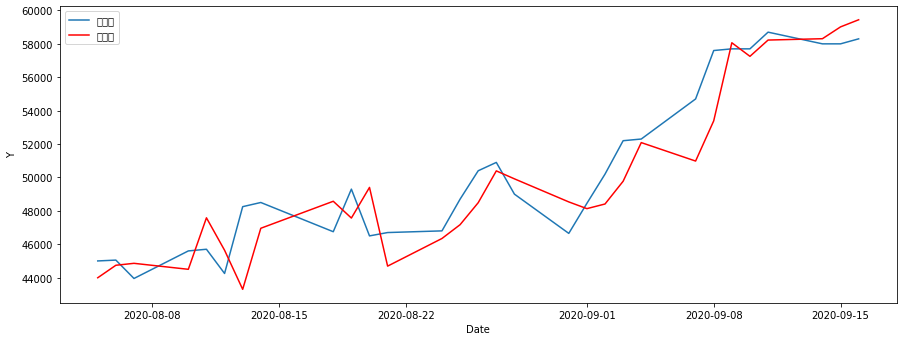

In [159]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자    ( https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=nzZ6wGntXBrP 참고)

# Validation 그래프
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(validation['종가'],label='실제값' )
ax1.plot(forecasts['종가'],color='red',label='예측값')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc=2)
plt.show

print('Validation Accuracy : \n')
print(f"Mean squared error: {mean_squared_error(validation['종가'], forecasts)}")
RMSE = mean_squared_error(validation['종가'], forecasts)**0.5
print(f"RMSE: {mean_squared_error(validation['종가'], forecasts)**0.5}")
print(f"SMAPE: {smape(validation['종가'], forecasts)}")

In [160]:
fc, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

In [161]:
# 상한, 하한 담기
cap=[]
floor=[]
for i in conf_int:
  cap.append(i[1])
  floor.append(i[0])


In [162]:
pred=pd.DataFrame({'yhat':fc,'upper':cap,'lower':floor},index=test.index)

In [163]:
pred

,yhat,upper,lower
날짜,,,
2020-09-17,58519.313153,61205.518276,55833.108030
2020-09-18,59183.117958,62981.985674,55384.250242
2020-09-21,60008.653454,64661.297207,55356.009702
2020-09-22,62378.680602,67751.090848,57006.270356
2020-09-23,62305.933215,68312.470471,56299.395958
2020-09-24,61368.667028,67948.498924,54788.835132
2020-09-25,64062.155557,71169.186283,56955.124831
2020-09-28,63913.515677,71511.251109,56315.780245
2020-09-29,64323.172254,72381.787622,56264.556885


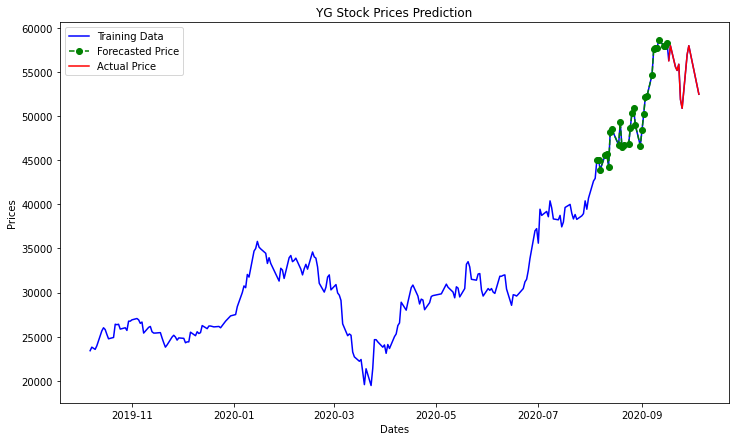

In [164]:
plt.figure(figsize=(12,7))
plt.plot(df['종가'], 'green', color='blue', label='Training Data')
plt.plot(validation.index,validation['종가'],color='green', marker='o', linestyle='dashed', label='Forecasted Price')
plt.plot(test.index, test['종가'], color='red', label='Actual Price')
plt.title('YG Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

Testset Accuracy : 

Mean squared error: 3631393.9906512704
RMSE: 1905.621680882979
SMAPE: 3.0609342064443257


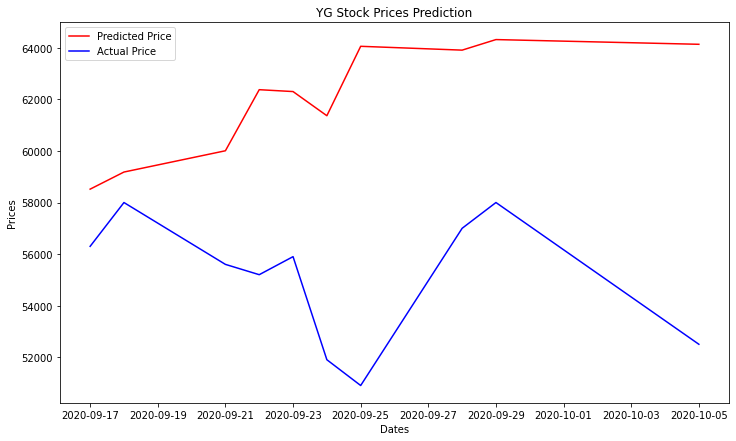

In [165]:
plt.figure(figsize=(12,7))
plt.plot(pred.index, pred['yhat'], color='red',label='Predicted Price')

plt.plot(test.index, test['종가'], color='blue', label='Actual Price')
plt.legend()
plt.title('YG Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(6386,7982, 300), df['Date'][6386:7982:300])
plt.legend()

print('Testset Accuracy : \n')
print(f"Mean squared error: {mean_squared_error(validation['종가'], forecasts)}")
RMSE = mean_squared_error(validation['종가'], forecasts)**0.5
print(f"RMSE: {mean_squared_error(validation['종가'], forecasts)**0.5}")
print(f"SMAPE: {smape(validation['종가'], forecasts)}")